# Testing IsoForest baseline on Kyoto-2006+ data


In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import precision_recall_fscore_support, precision_recall_curve, f1_score

pd.options.mode.chained_assignment = None 

In [8]:
def load_train_year(year):
    if year <= 2010:
        df = pd.read_parquet(f'../datasets/Kyoto-2016_AnoShift/subset/{year}_subset.parquet')
    else:
        import sys
        sys.exit(-1)
    df = df.reset_index(drop=True)
    print(df.shape)
    return df.sample(frac=0.05).dropna()

def load_test_year(year):
    if year <= 2010:
        df = pd.read_parquet(f'../datasets/Kyoto-2016_AnoShift/subset/{year}_subset_valid.parquet')
    else:
        df = pd.read_parquet(f'../datasets/Kyoto-2016_AnoShift/subset/{year}_subset.parquet')

    df = df.reset_index(drop=True)
    return df.sample(frac=0.05).dropna()


def rename_columns(df):    
    categorical_cols = ["0", "1", "2", "3"]
    numerical_cols = ["4", "5", "6", "7", "8", "9", "10", "11", "12"]
    additional_cols = ["14", "15", "16", "17", "19"]
    label_col = ["18"]

    new_names = []
    for col_name in df.columns.astype(str).values:
        if col_name in numerical_cols:
            df[col_name] = pd.to_numeric(df[col_name])
            new_names.append((col_name, "num_" + col_name))
        elif col_name in categorical_cols:
            new_names.append((col_name, "cat_" + col_name))
        elif col_name in additional_cols:
            new_names.append((col_name, "bonus_" + col_name))
        elif col_name in label_col:
            df[col_name] = pd.to_numeric(df[col_name])
            new_names.append((col_name, "label"))
        else:
            new_names.append((col_name, col_name))
    df.rename(columns=dict(new_names), inplace=True)
    
    return df

def preprocess(df, enc=None):
    if not enc:
        enc = OneHotEncoder(handle_unknown='ignore')
        enc.fit(df.loc[:,['cat_' in i for i in df.columns]])
    
    num_cat_features = enc.transform(df.loc[:,['cat_' in i for i in df.columns]]).toarray()

    df_catnum = pd.DataFrame(num_cat_features)
    df_catnum = df_catnum.add_prefix('catnum_')

    df.reset_index(drop=True)
    df_new = pd.concat([df,  df_catnum], axis=1)
    
    
    filter_clear = df_new["label"] == 1
    filter_infected = df_new["label"] < 0
    df_new["label"][filter_clear] = 0
    df_new["label"][filter_infected] = 1

    return df_new, enc


def print_results(labels, preds, text="?", normalize="true", th=0.5):
    precision_anom, recall_anom, th_anom = precision_recall_curve(labels, preds, pos_label=1)
    precision_norm, recall_norm, th_norm = precision_recall_curve(labels, 1-np.array(preds), pos_label=0)
    
    prec, recall, _, _ = precision_recall_fscore_support(labels, np.array(preds)>=th)
    f1_norm, f1_anom = f1_score(labels, np.array(preds)>=th, average=None)
    
    # Use AUC function to calculate the area under the curve of precision recall curve
    pr_auc_norm = auc(recall_norm, precision_norm)
    pr_auc_anom = auc(recall_anom, precision_anom)
    
    roc_auc = roc_auc_score(labels, preds)
    
    print("[%s] ROC-AUC     %.2f%% | PR-AUC-norm    %.2f%% | PR-AUC-anom    %.2f%%" % (text, roc_auc*100, pr_auc_norm*100, pr_auc_anom*100))
    global_roc.append(roc_auc*100)
    global_pr_norm.append(pr_auc_norm*100)
    global_pr_anom.append(pr_auc_anom*100)

    return f1_anom, pr_auc_anom

In [9]:
def get_train(train_years):
    dfs = []

    for year in train_years:
        df_year = load_train_year(year)
        dfs.append(df_year)

    df_all_years = pd.concat(dfs, ignore_index=True)
    df_all_years = rename_columns(df_all_years)
    df_new, ohe_enc = preprocess(df_all_years)

    # split train + val
    X_train, X_val = train_test_split(df_new, test_size=0.001, random_state=0, shuffle=True)

    # prepare for isoforest
    isoforest_cols = df_new.columns.to_numpy()[['num_' in i for i in df_new.columns]]

    X_train_clear = X_train[X_train["label"] == 0]
    X_train_iso = X_train_clear[isoforest_cols].to_numpy()

    X_val_iso = X_val[isoforest_cols].to_numpy()
    y_val_iso = X_val["label"].to_numpy()
    return X_train_iso, X_val_iso, y_val_iso, isoforest_cols, ohe_enc

[2006, 2007, 2008] [2006, 2007, 2008]
(466774, 20)
(415471, 20)
(374713, 20)


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    1.1s remaining:    4.4s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    1.2s finished


Done fitting
[2006] ROC-AUC     22.22% | PR-AUC-norm    40.04% | PR-AUC-anom    31.95%
[2007] ROC-AUC     39.66% | PR-AUC-norm    86.18% | PR-AUC-anom    11.48%
[2008] ROC-AUC     35.78% | PR-AUC-norm    89.72% | PR-AUC-anom    7.56%
[2006, 2007, 2008] [2006, 2007, 2008] 10
22.22	39.66	35.78	
40.04	86.18	89.72	
31.95	11.48	7.56	




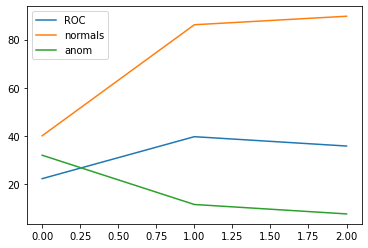

[2006, 2007, 2008] [2006, 2007, 2008]
(466774, 20)
(415471, 20)
(374713, 20)


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    1.1s remaining:    4.3s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    1.2s finished


Done fitting
[2006] ROC-AUC     18.15% | PR-AUC-norm    40.04% | PR-AUC-anom    30.81%
[2007] ROC-AUC     42.92% | PR-AUC-norm    88.08% | PR-AUC-anom    11.26%
[2008] ROC-AUC     37.57% | PR-AUC-norm    89.91% | PR-AUC-anom    7.91%
[2006, 2007, 2008] [2006, 2007, 2008] 15
18.15	42.92	37.57	
40.04	88.08	89.91	
30.81	11.26	7.91	




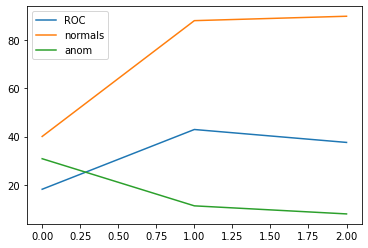

[2006, 2007, 2008] [2006, 2007, 2008]
(466774, 20)
(415471, 20)
(374713, 20)


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    1.1s remaining:    4.4s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    1.2s finished


Done fitting
[2006] ROC-AUC     15.49% | PR-AUC-norm    37.90% | PR-AUC-anom    29.77%
[2007] ROC-AUC     41.33% | PR-AUC-norm    87.64% | PR-AUC-anom    10.85%
[2008] ROC-AUC     38.00% | PR-AUC-norm    90.20% | PR-AUC-anom    7.70%
[2006, 2007, 2008] [2006, 2007, 2008] 20
15.49	41.33	38.00	
37.90	87.64	90.20	
29.77	10.85	7.70	




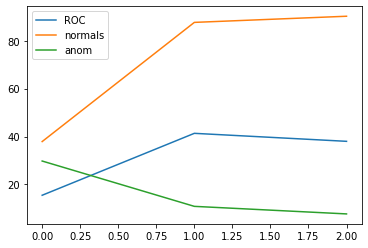

In [10]:
pair_years = []
pair_years.append(([2006, 2007, 2008,], [2006, 2007, 2008, ]))
    
for rs in [10, 15, 20]:
    for train_years, test_years in pair_years:
        global_roc = []
        global_pr_norm = []
        global_pr_anom = []

        print(train_years, test_years)
        X_train_iso, X_val_iso, y_val_iso, isoforest_cols, ohe_enc = get_train(train_years)

        clf = IsolationForest(random_state=rs,
                          n_estimators=101,
                          max_samples=1.0,
                          max_features=1.0,
                          verbose=1,
                          warm_start=False,
                          n_jobs=10)
        clf.fit(X_train_iso)

        del X_train_iso
            
        print("Done fitting")
        for year in test_years:
            df_year = load_test_year(year)
            df_year = rename_columns(df_year)
            df_test, _ = preprocess(df_year, ohe_enc)

            X_test = df_test[isoforest_cols].to_numpy()
            y_test = df_test["label"].to_numpy()

            X_test = np.nan_to_num(X_test)

            predict_test = (-1) * clf.score_samples(X_test)
            predict_test = np.nan_to_num(predict_test, 0)
            y_test = np.nan_to_num(y_test, 0)
            print_results(y_test, predict_test, text=str(year), normalize=None, th=0.35)
            del df_test, df_year, X_test

        print(train_years, test_years, rs)
        for i, year in enumerate(test_years):
            print("%.2f\t" % (global_roc[i]), end = '')
        print("")
        for i, year in enumerate(test_years):
            print("%.2f\t" % (global_pr_norm[i]), end = '')
        print("")

        for i, year in enumerate(test_years):
            print("%.2f\t" % (global_pr_anom[i]), end = '')
        print("\n===================================\n\n")

        plt.plot(global_roc, label='ROC')
        plt.plot(global_pr_norm, label="normals")
        plt.plot(global_pr_anom, label='anom')
        plt.legend()
        plt.show()
